In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
apr = pd.read_csv(r'../../../data/uber-raw-data-apr14.csv')

In [3]:
apr.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [4]:
apr.dtypes

Date/Time     object
Lat          float64
Lon          float64
Base          object
dtype: object

In [5]:
from datetime import datetime

In [6]:
apr['Date/Time'].iloc[0]

'4/1/2014 0:11:00'

In [7]:
# call datetime.strptime to convert
# it into datetime datatype
datetime_obj = datetime.strptime(apr['Date/Time'].iloc[0], 
                                 "%m/%d/%Y %H:%M:%S")

  
# extract the time from datetime_obj
hours = datetime_obj.time().hour
apr['Hour'] = apr['Date/Time'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M:%S").time().hour)
apr.drop('Date/Time', axis=1, inplace=True)
apr.drop('Base', axis=1, inplace=True)


0


In [13]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

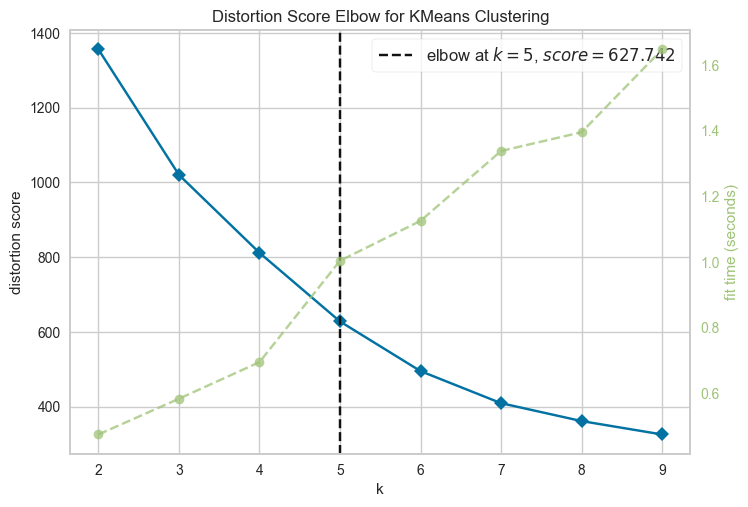

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [63]:
model = KMeans()
visualizer = KElbowVisualizer(estimator = model, k = (2,10))
visualizer.fit(apr[['Lat', 'Lon']])
visualizer.poof()

In [81]:
model = KMeans(6, random_state=42)
model.fit(apr[['Lat', 'Lon']])
y_pred = model.predict(apr[['Lat', 'Lon']])

In [82]:
y_pred

array([0, 2, 2, ..., 2, 1, 1], dtype=int32)

In [83]:
np.unique(y_pred, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([216680,  59915, 249523,  14407,  19134,   4857]))

In [84]:
model.cluster_centers_

array([[ 40.76556828, -73.97281182],
       [ 40.68856834, -73.96549626],
       [ 40.73111913, -73.9985994 ],
       [ 40.65951061, -73.77406315],
       [ 40.79807196, -73.86873733],
       [ 40.7005414 , -74.20167303]])

In [85]:
apr['Kcluster'] = model.labels_

In [86]:
apr.head()

,Lat,Lon,Hour,Kcluster
0,40.7690,-73.9549,0,0
1,40.7267,-74.0345,0,2
2,40.7316,-73.9873,0,2
3,40.7588,-73.9776,0,0
4,40.7594,-73.9722,0,0


In [87]:
sample = apr.sample(frac=0.02, random_state=42)

In [119]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [120]:
for eps in np.round(np.arange(0.02, 0.03, 0.001),3):
    dbscan_cluster = DBSCAN(eps=eps)
    dbscan_cluster = dbscan_cluster.fit(sample[['Lat', 'Lon']])
    ypred = dbscan_cluster.fit_predict(sample[['Lat', 'Lon']])
    print("eps is:", eps)
    print("Score is:", metrics.silhouette_score(sample[['Lat', 'Lon']], ypred, metric="sqeuclidean"))

eps is: 0.02
Score is: 0.8140154635161284
eps is: 0.021
Score is: 0.8137883613995639
eps is: 0.022
Score is: 0.871267598044826
eps is: 0.023
Score is: 0.8578741148017804
eps is: 0.024
Score is: 0.870654259300429
eps is: 0.025
Score is: 0.8706084826481892
eps is: 0.026
Score is: 0.8122149756957635
eps is: 0.027
Score is: 0.8122149756957635
eps is: 0.028
Score is: 0.8120675265773107
eps is: 0.029
Score is: 0.8122120657239045


In [121]:
dbscan_cluster = DBSCAN(eps=0.022)
dbscan_cluster = dbscan_cluster.fit(sample[['Lat', 'Lon']])
ypred = dbscan_cluster.fit_predict(sample[['Lat', 'Lon']])

In [122]:
sample['DBcluster'] = ypred

In [123]:
sample.head()

,Lat,Lon,Hour,Kcluster,DBcluster
77202,40.8021,-73.9654,10,0,0
558915,40.6462,-73.7769,4,3,1
152635,40.7747,-73.9603,9,0,0
361259,40.7150,-74.0157,23,2,0
60087,40.7335,-74.0080,19,2,0


In [124]:
np.unique(ypred, return_counts=True)

(array([-1,  0,  1,  2,  3]), array([   95, 10877,   233,    78,     7]))

In [125]:
np.unique(ypred)

array([-1,  0,  1,  2,  3])

In [126]:
sample.loc[sample['DBcluster'] == -1]['Lon'].mean()

-73.88714526315789

In [127]:
centroids = []
for label in np.unique(ypred):
    centroids.append([sample.loc[sample['DBcluster'] == label]['Lat'].mean(),sample.loc[sample['DBcluster'] == label]['Lon'].mean()])

In [128]:
import folium
from folium.plugins import HeatMap

In [129]:
map = folium.Map(location=(sample['Lat'].mean(), sample['Lon'].mean()), zoom_start=10.5)

# Create the Heat Map
HeatMap(list(zip(sample['Lat'], sample['Lon']))).add_to(map)

for point in model.cluster_centers_:
    folium.Marker(location=(point[0], point[1]), icon=folium.Icon(icon="car", prefix='fa', color='gray')).add_to(map)

for point in centroids:
    folium.Marker(location=(point[0], point[1]), icon=folium.Icon(icon="car", prefix='fa', color='pink')).add_to(map)

map

<AxesSubplot: xlabel='Kcluster', ylabel='Hour'>

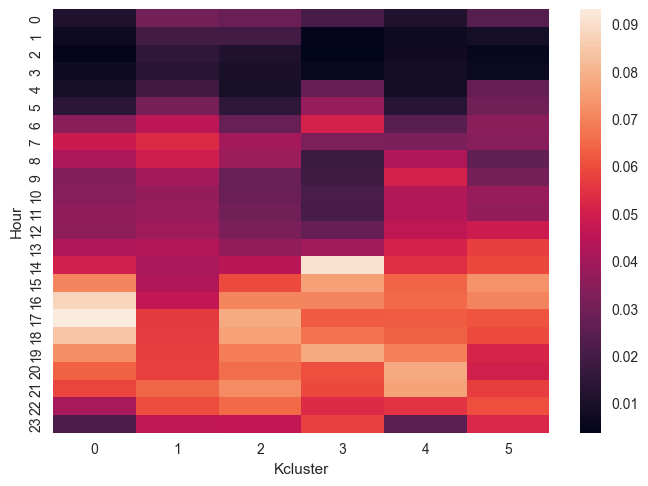

In [130]:
sns.heatmap(pd.crosstab(apr.Hour, apr.Kcluster, normalize='columns'))

<AxesSubplot: xlabel='DBcluster', ylabel='Hour'>

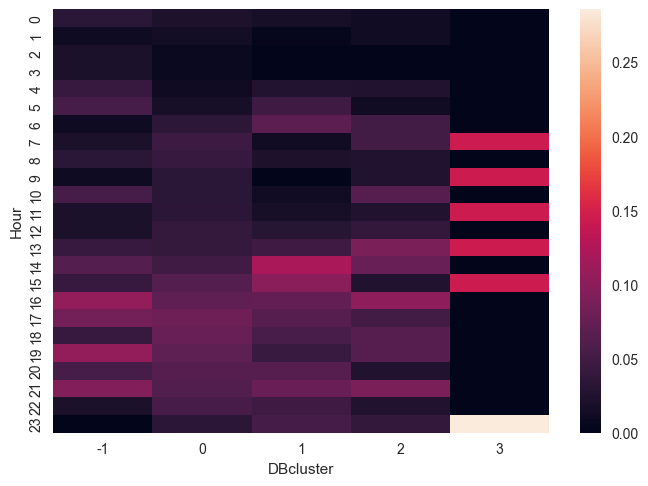

In [131]:
sns.heatmap(pd.crosstab(sample.Hour, sample['DBcluster'], normalize='columns'))

In [103]:
sept = pd.read_csv(r'../../../data/uber-raw-data-sep14.csv')

In [104]:
datetime_obj = datetime.strptime(sept['Date/Time'].iloc[0], 
                                 "%m/%d/%Y %H:%M:%S")

  
# extract the time from datetime_obj
hours = datetime_obj.time().hour
sept['Hour'] = sept['Date/Time'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M:%S").time().hour)
sept.drop('Date/Time', axis=1, inplace=True)
sept.drop('Base', axis=1, inplace=True)


In [105]:
sept.head()

,Lat,Lon,Hour
0,40.2201,-74.0021,0
1,40.7500,-74.0027,0
2,40.7559,-73.9864,0
3,40.7450,-73.9889,0
4,40.8145,-73.9444,0


In [107]:
sept_sample = sept.sample(frac=0.02, random_state=42)

In [132]:
map = folium.Map(location=(sept_sample['Lat'].mean(), sept_sample['Lon'].mean()), zoom_start=10.5)

# Create the Heat Map
HeatMap(list(zip(sept_sample['Lat'], sept_sample['Lon']))).add_to(map)

for point in model.cluster_centers_:
    folium.Marker(location=(point[0], point[1]), icon=folium.Icon(icon="car", prefix='fa', color='gray')).add_to(map)

for point in centroids:
    folium.Marker(location=(point[0], point[1]), icon=folium.Icon(icon="car", prefix='fa', color='pink')).add_to(map)

map

In [133]:
print("Silhouette Coefficient for KMeans: %0.3f \n"
    % metrics.silhouette_score(sample[['Lat', 'Lon']], sample['Kcluster'], metric="sqeuclidean"))

print("Silhouette Coefficient for DBSCAN: %0.3f \n"
    % metrics.silhouette_score(sample[['Lat', 'Lon']], sample['DBcluster'], metric="sqeuclidean"))

Silhouette Coefficient for KMeans: 0.628 

Silhouette Coefficient for DBSCAN: 0.871 

